### EDA 2018


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('2018EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [3]:
df_2018 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2018", inferSchema=True, header=True)
# figure out how to read in shp file msca-bdp-student-gcs/bdp-rideshare-project/neighborhoods/shp files
#df_weather = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2020-01-01 to 2018-08-31.csv", inferSchema=True, header=True)
df_2018.printSchema()
#df_weather.printSchema()

23/11/16 16:32:44 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 4 for reason Container marked as failed: container_1700149116910_0002_01_000005 on host: hub-msca-bdp-dphub-students-harshpachisia-sw-tqgf.c.msca-bdp-student-ap.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/11/16 16:32:44 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 2 on hub-msca-bdp-dphub-students-harshpachisia-sw-tqgf.c.msca-bdp-student-ap.internal: Container marked as failed: container_1700149116910_0002_01_000002 on host: hub-msca-bdp-dphub-students-harshpachisia-sw-tqgf.c.msca-bdp-student-ap.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/11/16 16:32:44 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container marked as failed: container_1700149116910_0002_01_000002 

root
 |-- Trip ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- Additional Charges: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Shared Trip Authorized: boolean (nullable = true)
 |-- Trips Pooled: integer (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Dropof

In [4]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2018.rdd.getNumPartitions()

36

In [5]:
displaypartitions(df_2018)

Partitions: 36


+-----------+------+
|partitionId| count|
+-----------+------+
|         35|469234|
|         18|479815|
|         27|480391|
|         10|480490|
|         22|480737|
|          1|481131|
|          5|481340|
|          6|481474|
|         26|481475|
|         23|481921|
|         17|483047|
|          9|484292|
|         31|484425|
|         21|484784|
|          8|484788|
|         16|484924|
|         34|485026|
|          4|485366|
|         30|485595|
|         11|485972|
|         20|486010|
|          2|486281|
|         29|486281|
|          0|486500|
|         25|486535|
|          3|486629|
|         28|486697|
|         24|487132|
|         12|487458|
|         19|488178|
|         15|488213|
|         14|488632|
|          7|488736|
|         13|492872|
|         33|493564|
|         32|495508|
+-----------+------+



In [6]:
# df_2018 = df_2018.repartition(10)

In [7]:
df_2018.describe().show()

+-------+--------------------+--------------------+--------------------+-----------------+-----------------+--------------------+--------------------+---------------------+----------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|summary|             Trip ID|Trip Start Timestamp|  Trip End Timestamp|     Trip Seconds|       Trip Miles| Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|             Fare|               Tip|Additional Charges|        Trip Total|      Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+--------------------+--------------------+-----------------+-----------------+--

In [8]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df_2018.select([count(when(df_2018[c].isNull(), c)).alias(c) for c in df_2018.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------

<AxesSubplot:>

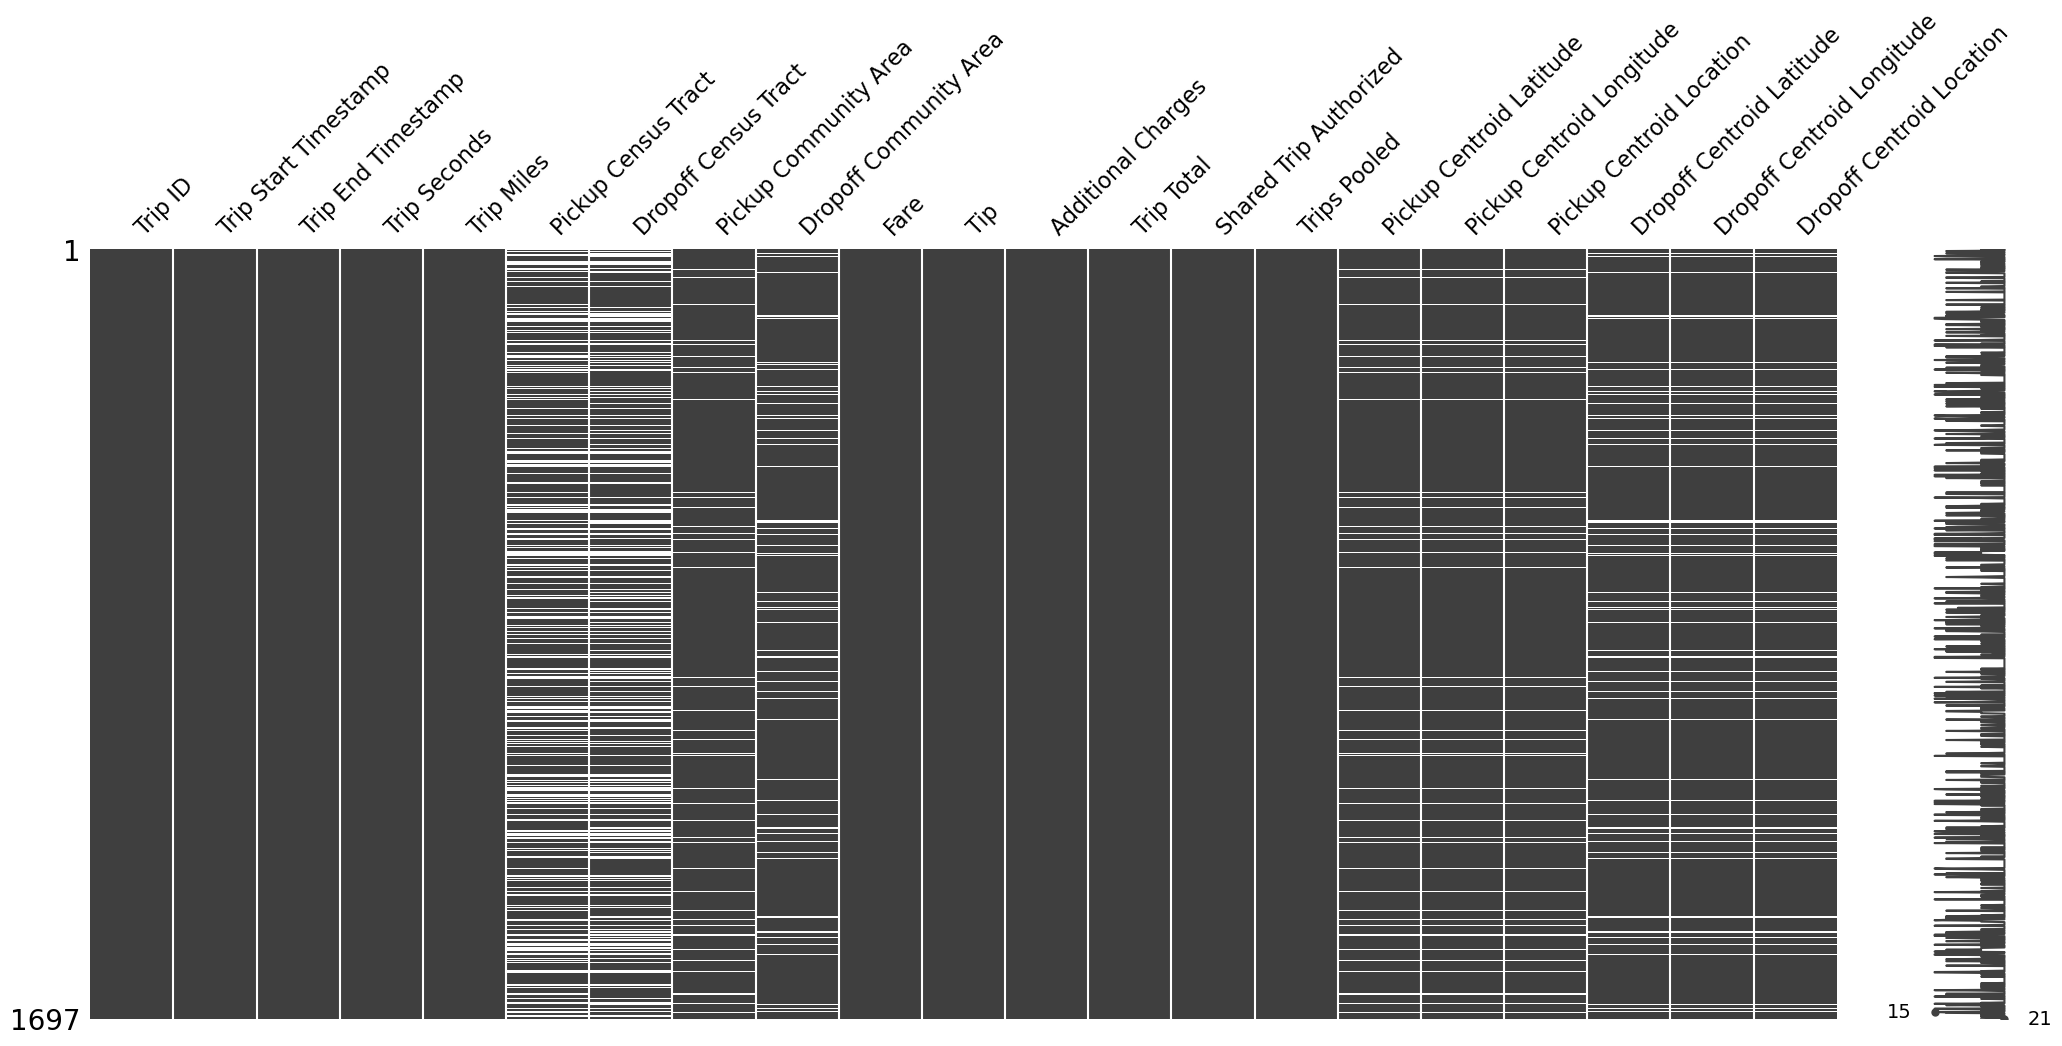

In [9]:
import missingno as msno
%matplotlib inline
msno.matrix(df_2018.sample(fraction=1/10000).toPandas())

In [10]:
#Approximate number of 2018 trips
from pyspark.sql.functions import approxCountDistinct

df_2018.select(approxCountDistinct("Trip ID", rsd = 0.01)).show()

23/11/16 16:34:11 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+
|approx_count_distinct(Trip ID)|
+------------------------------+
|                      17414220|
+------------------------------+



In [11]:
# number of observations with all the data in each column
df_2018.dropna(how='any').count()

11737942

In [12]:
# Working with just data that contains full information and check for dupes
df_2018 = df_2018.dropna(how='any', subset=['Trip Start Timestamp','Trip End Timestamp','Fare','Dropoff Community Area','Pickup Community Area'])
df_2018 = df_2018.dropDuplicates()
# df_2018.count()

In [13]:
# Drop columns unlikely to be useful for analysis for speed of computation and rename columns to remove spacing for ease of code writing
#spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_2018 = df_2018.drop('Trips Pooled','Additional Charges','Shared Trip Authorized','Pickup Centroid Location','Dropoff Centroid Location')
df_2018 = df_2018.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Location","dropoff_location").withColumnRenamed("Trip Seconds","seconds")
# fix datatypes
df_2018 = df_2018.withColumn('start_timestamp', F.to_timestamp(df_2018['start_timestamp'], 'MM/dd/yyyy hh:mm:ss a')).withColumn('end_timestamp', F.to_timestamp(df_2018['end_timestamp'], 'MM/dd/yyyy hh:mm:ss a'))
#df_weather = df_weather.withColumn('datetime',F.to_date(df_weather['datetime'], "yyyy-MM-dd"))


In [14]:
# add the month column
df_2018 = df_2018.withColumn('month', F.month(df_2018.start_timestamp))
df_2018 = df_2018.withColumn('day_of_month', F.dayofmonth(df_2018.start_timestamp))
df_2018 = df_2018.withColumn('hour', F.hour(df_2018.start_timestamp))
df_2018 = df_2018.withColumn('day', F.dayofweek(df_2018.start_timestamp))

In [15]:
sample_df = df_2018.sample(fraction=1/10000).toPandas().loc[:,["pickup_area","dropoff_area","total","Fare","Tip","total","miles","seconds","hour","day","month"]]

In [16]:
sample_df.head()

,pickup_area,dropoff_area,total,Fare,Tip,total,miles,seconds,hour,day,month
0,32,76,45.0,27.5,10,45.0,17.7,2543.0,11,5,11
1,13,2,5.0,2.5,0,5.0,2.9,426.0,1,1,12
2,74,75,8.5,5.0,1,8.5,2.0,338.0,7,7,11
3,76,35,32.5,25.0,0,32.5,25.5,3488.0,11,1,11
4,28,25,10.0,10.0,0,10.0,4.6,922.0,11,3,11


In [17]:
sample_df = sample_df.dropna()
sample_df = sample_df.drop_duplicates()

In [18]:
sample_df.head()
sample_df = sample_df.drop(columns='total')

In [19]:
#import seaborn as sns
#sns.set_theme(style="ticks")
#sns.pairplot(sample_df)
#plt.show()

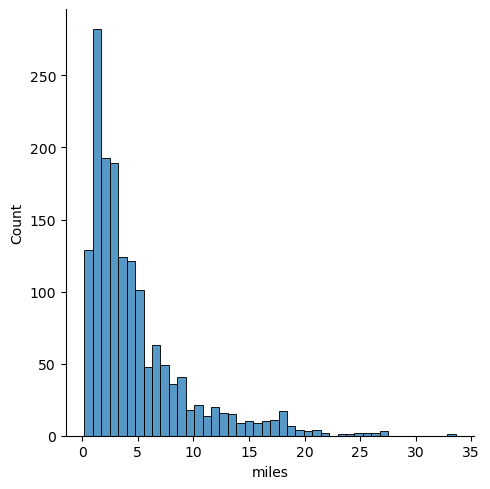

In [20]:
import seaborn as sns
sns.displot(sample_df, x="miles")

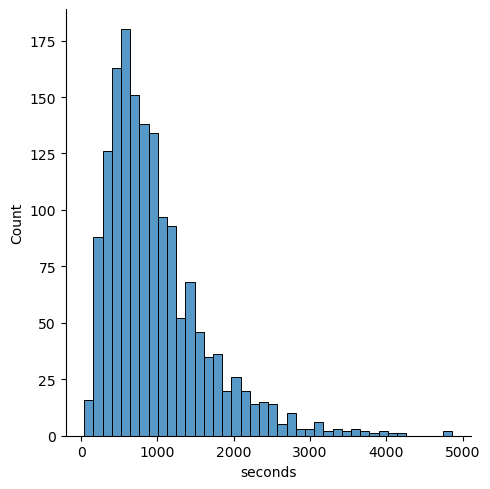

In [21]:
sns.displot(sample_df, x="seconds")

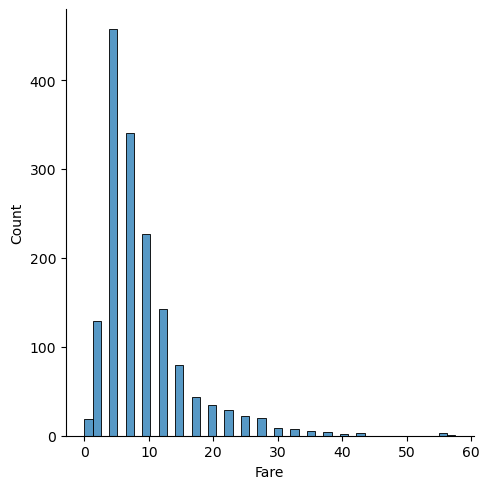

In [22]:
sns.displot(sample_df, x="Fare")

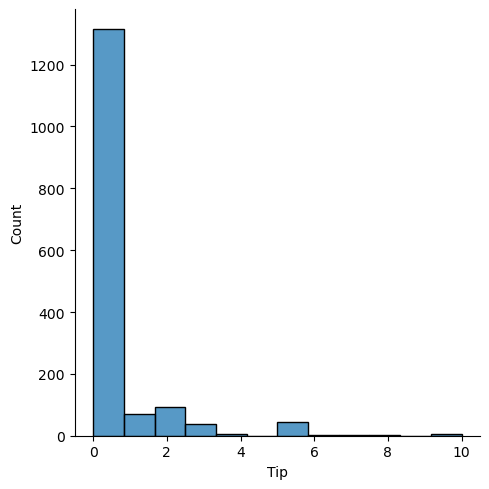

In [23]:
sns.displot(sample_df, x="Tip")

In [24]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2018.filter((df_2018.pickup_area == 41) & (df_2018.dropoff_area == 41))
df_kw = df_2018.filter(((df_2018.pickup_area == 41) & (df_2018.dropoff_area == 42)) | ((df_2018.pickup_area == 42) & (df_2018.dropoff_area == 41)))
df_wl = df_2018.filter(((df_2018.pickup_area == 41) & (df_2018.dropoff_area == 39)) | ((df_2018.pickup_area == 39) & (df_2018.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

In [25]:
df_area.show(5)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|   pickup_lat|    pickup_lon|  dropoff_lat|   dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|b21ea28400b2f28f0...|2018-11-01 02:00:00|2018-11-01 02:00:00|    165|  0.6|        null|         null|         41|          41| 2.5|  0|  5.0| 41.794090253| -87.592310855| 41.794090253| -87.592310855|   11|           1|   2|  5|
|19f4d3623823ca6d8...|2018-11-01 08:15:00|2018-11-01 08:15:00|    287|  0.9| 170

In [37]:
import matplotlib.pyplot as plt


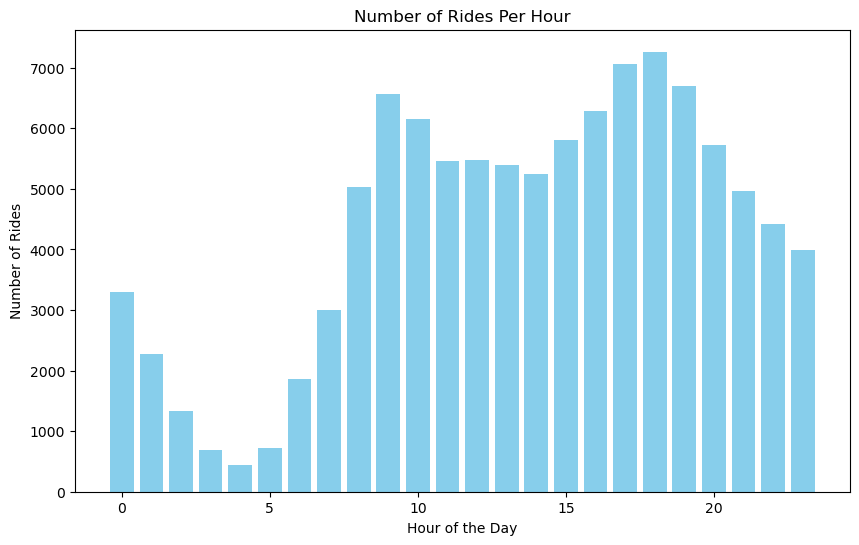

In [27]:
# rides per hour:
rides_per_hour = df_area.groupBy("hour").count().orderBy("hour")

# Convert the result to Pandas for local plotting
rides_per_hour_pd = rides_per_hour.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(rides_per_hour_pd["hour"], rides_per_hour_pd["count"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Per Hour")
plt.show()

In [28]:
df_area_program = df_area.filter((df_area.Fare <= 15.0) & ((df_area.hour >= 17) | (df_area.hour < 4)))

In [29]:
from pyspark.sql.functions import approxCountDistinct

df_area_program.select(approxCountDistinct("ID", rsd = 0.05)).show()

+-------------------------+
|approx_count_distinct(ID)|
+-------------------------+
|                    50357|
+-------------------------+



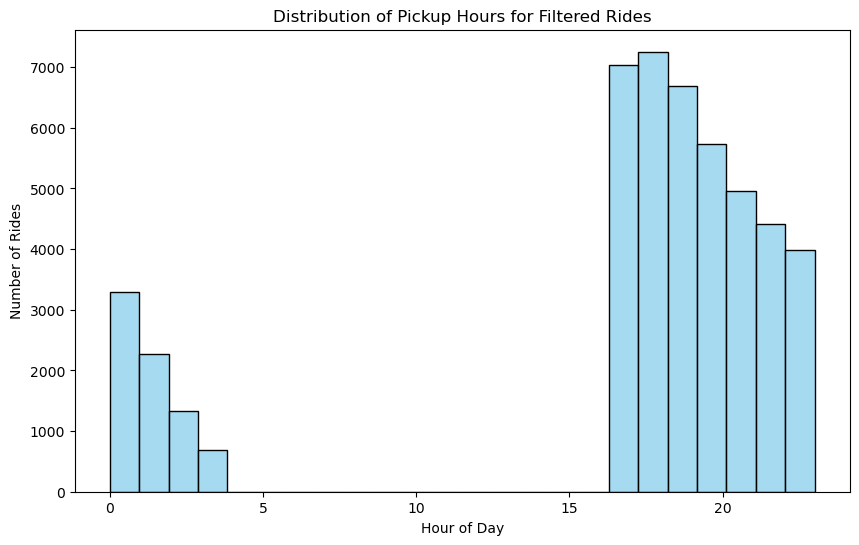

In [31]:
import seaborn as sns

df_area_program_pd = df_area_program.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_area_program_pd['hour'], bins=24, kde=False, color='skyblue')
plt.title('Distribution of Pickup Hours for Filtered Rides')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

<AxesSubplot:xlabel='month'>

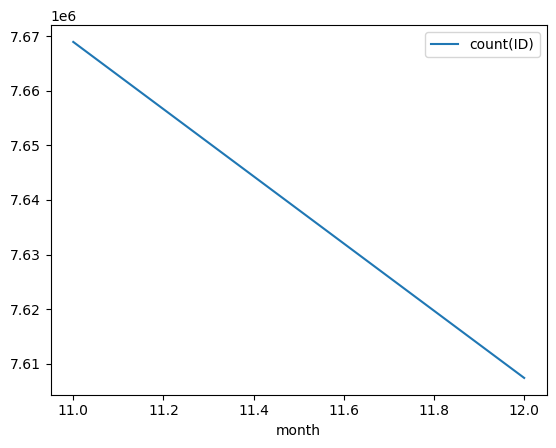

In [32]:
# basic plots for all rides (not just in the program area)
df_2018.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

In [33]:
df_total = df_2018.groupby("pickup_area").agg({'ID':'count'}).orderBy(F.col('pickup_area').asc()).toPandas()

<Figure size 1000x1000 with 0 Axes>

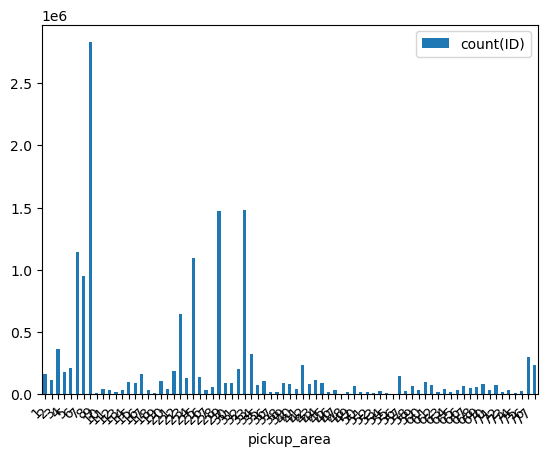

In [34]:
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = df_total.plot(x="pickup_area",y="count(ID)", kind='bar')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

<AxesSubplot:xlabel='dropoff_area'>

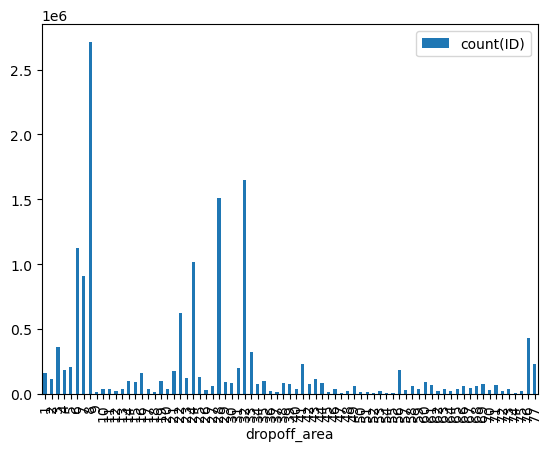

In [35]:
df_2018.groupby("dropoff_area").agg({'ID':'count'}).orderBy(F.col('dropoff_area').asc()).toPandas().plot(x="dropoff_area",y="count(ID)", kind='bar')

In [36]:
# storing data on the bucket
df_area_program.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2018.csv")
df_2018.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2018.csv")
